# Treynor-Black Model: Active Portfolio Management
# Investment Management MBA Class Example


## 1. Introduction to the Treynor-Black Model
The Treynor-Black model is a portfolio optimization approach that combines:
 - A passive investment in the market portfolio (the "core" portfolio)
 - An active investment in securities where the investor has "views" (the "satellite" portfolio)

The model allows an investor to:
 1. Efficiently combine new information with an otherwise efficient portfolio
 2. Construct an active portfolio based on alpha estimates
 3. Determine how much to allocate to active vs. passive investments

In [122]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize
import seaborn as sns
from sklearn.linear_model import LinearRegression
import datetime as dt

# Set styling for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (12, 6)

In [55]:
# ## 2. Data Preparation

# ### 2.1 Download Stock and Market Data
# Let's get 5 years of data for several stocks and the S&P 500 index

def get_stock_data(tickers, start_date, end_date):
    """
    Download historical stock data for a list of tickers
    """
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    returns = data.pct_change().dropna()
    return returns

# Define date range - 5 years of data
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=5*365)

# Define tickers - we'll use some popular stocks and the S&P 500 index
market_ticker = '^GSPC'  # S&P 500
stock_tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'NVDA', 'JPM', 'V', 'WMT']

# Combined list with market first (important for later calculations)
tickers = [market_ticker] + stock_tickers

# Download the data
returns = get_stock_data(tickers, start_date, end_date)

# Calculate excess returns (we'll use a constant risk-free rate for simplicity)
risk_free_rate = 0.03/252  # Approximate daily risk-free rate (3% annual)
excess_returns = returns.subtract(risk_free_rate, axis=0)

[*********************100%***********************]  11 of 11 completed



## 3. Single Index Model Estimation
 
We need to estimate the parameters of the CAPM regression:
 
r_i - r_f = α_i + β_i(r_m - r_f) + ε_i
 
 For each stock, we'll estimate:
 - Alpha (α): abnormal return
 - Beta (β): sensitivity to market movement
 - Idiosyncratic risk (σ²(ε)): stock-specific risk

In [56]:

def estimate_single_index_model(excess_returns, market_index=-1):
    """
    Estimate alphas, betas and residual variances using the single index model
    """
    # Separate market excess returns
    market_excess_returns = excess_returns.iloc[:, market_index]

    # Initialize results dictionary
    results = {
        'alpha': {},
        'beta': {},
        'residual_var': {},
        'total_var': {},
        'r_squared': {},
        'market_excess_returns': np.mean(market_excess_returns.values) * 252  # Annualize market excess return
    }

    # Estimate parameters for each stock
    for i, ticker in enumerate(excess_returns.columns):
        if i == market_index:  # Skip the market itself
            continue

        # Prepare data for regression
        X = market_excess_returns.values.reshape(-1, 1)
        y = excess_returns.iloc[:, i].values

        # Fit linear regression model
        model = LinearRegression()
        model.fit(X, y)

        # Extract parameters
        beta = model.coef_[0]
        alpha = model.intercept_

        # Calculate residuals and their variance
        y_pred = model.predict(X)
        residuals = y - y_pred
        residual_var = np.var(residuals, ddof=1)

        # Calculate R-squared
        r_squared = model.score(X, y)

        # Calculate total variance
        total_var = np.var(y, ddof=1)

        # Store results
        results['alpha'][ticker] = alpha * 252  # Annualize alpha
        results['beta'][ticker] = beta
        results['residual_var'][ticker] = residual_var * \
            252  # Annualize variance
        results['total_var'][ticker] = total_var * 252  # Annualize variance
        results['r_squared'][ticker] = r_squared

    return results

In [57]:

# Run the single index model estimation
sim_results = estimate_single_index_model(
    excess_returns, len(excess_returns.columns)-1)

# Convert results to DataFrames for easier handling
alpha_df = pd.DataFrame({'alpha': sim_results['alpha']}).T
beta_df = pd.DataFrame({'beta': sim_results['beta']}).T
resid_var_df = pd.DataFrame({'residual_var': sim_results['residual_var']}).T
r_squared_df = pd.DataFrame({'r_squared': sim_results['r_squared']}).T

# Combine results
sim_summary = pd.concat([
    alpha_df.T,
    beta_df.T,
    resid_var_df.T,
    r_squared_df.T
], axis = 1)

print(sim_summary)
print(sim_results['market_excess_returns'])

          alpha      beta  residual_var  r_squared
AAPL   0.092704  1.197401      0.038458   0.539211
AMZN  -0.012581  1.333034      0.067665   0.451843
GOOGL  0.051553  1.257510      0.046845   0.514458
JPM    0.085782  0.966420      0.049789   0.370592
META   0.120075  1.496719      0.119843   0.369771
MSFT   0.030925  1.187526      0.029710   0.598372
NVDA   0.410344  2.009764      0.149568   0.458773
TSLA   0.321708  1.860535      0.299496   0.266209
V      0.010983  0.963481      0.029565   0.496363
WMT    0.121974  0.415683      0.037878   0.125253
0.14354527651251064



## 4. Treynor-Black Model Implementation

In [85]:
def treynor_black_model(alpha, beta, resid_var, market_variance, risk_free_rate, market_excess_return):
    """
    Implement the Treynor-Black model to construct an optimal active portfolio
    and determine allocation between active and passive components
    
    Parameters:
    -----------
    alpha : dict or Series
        Dictionary or Series of alpha estimates for each stock
    beta : dict or Series
        Dictionary or Series of beta estimates for each stock
    resid_var : dict or Series
        Dictionary or Series of residual variances for each stock
    market_variance : float
        Variance of the market returns (annualized)
    risk_free_rate : float
        Annual risk-free rate
        
    Returns:
    --------
    dict
        Dictionary containing optimal weights and other portfolio metrics
    """
    # Convert inputs to Series if they're dictionaries
    if isinstance(alpha, dict):
        alpha = pd.Series(alpha)
    if isinstance(beta, dict):
        beta = pd.Series(beta)
    if isinstance(resid_var, dict):
        resid_var = pd.Series(resid_var)

    # Ensure all inputs have the same stocks in the same order
    stocks = alpha.index
    alpha = alpha[stocks]
    beta = beta[stocks]
    resid_var = resid_var[stocks]

    # Step 1: Construct the active portfolio weights
    # w_i^0 = (α_i / σ²(ε)_i) / Σ(α_j / σ²(ε)_j)
    alpha_div_resid = alpha / resid_var
    sum_alpha_div_resid = alpha_div_resid.sum()
    active_weights = alpha_div_resid / sum_alpha_div_resid

    # Step 2: Calculate active portfolio characteristics
    active_alpha = (active_weights * alpha).sum()
    active_beta = (active_weights * beta).sum()
    active_resid_var = ((active_weights**2) * resid_var).sum()

    # Step 3: Calculate the optimal allocation to the active portfolio
    # w_A = (α_A/σ²_A(ε)) / [E(r_m-r_f)/σ²_m + (1-β_A)(α_A/σ²_A(ε))]
    numerator = active_alpha / active_resid_var
    denominator = market_excess_return / market_variance + \
        (1 - active_beta) * (active_alpha / active_resid_var)
    weight_active = numerator / denominator

    # Ensure weight_active is reasonable? (e.g., between 0 and 1 for long-only)
    #weight_active = np.clip(weight_active, 0, 1)
    weight_market = 1 - weight_active

    # Step 4: Calculate final stock weights in the overall portfolio
    final_weights = pd.Series(
        active_weights * weight_active,
        index=stocks
    )

    # Calculate expected portfolio return and risk
    portfolio_alpha = active_alpha * weight_active
    portfolio_beta = active_beta * weight_active + 1 * weight_market
    portfolio_expected_return = risk_free_rate + \
        (portfolio_beta * market_excess_return) + portfolio_alpha
    portfolio_variance = (portfolio_beta**2) * market_variance + \
        (weight_active**2) * active_resid_var
    portfolio_sharpe = (portfolio_expected_return -
                        risk_free_rate) / np.sqrt(portfolio_variance)

    # Calculate market Sharpe ratio for comparison
    market_sharpe = market_excess_return / np.sqrt(market_variance)

    # Step 6: Return the results
    return {
        'active_weights': active_weights,
        'active_portfolio_allocation': weight_active,
        'market_portfolio_allocation': weight_market,
        'final_weights': final_weights,
        'active_alpha': active_alpha,
        'active_beta': active_beta,
        'active_residual_var': active_resid_var,
        'portfolio_alpha': portfolio_alpha,
        'portfolio_beta': portfolio_beta,
        'portfolio_expected_return': portfolio_expected_return,
        'portfolio_variance': portfolio_variance,
        'portfolio_sharpe': portfolio_sharpe,
        'market_sharpe': market_sharpe
    }



In [ ]:
# Calculate market variance
market_variance = np.var(
    excess_returns.iloc[:, -1].values, ddof=1) * 252  # Annualized
# Calculate market excess return
market_excess_return = np.mean(
    excess_returns.iloc[:, -1].values) * 252  # Annualized

# Annualized risk-free rate
annual_rf = 0.03

# Run the Treynor-Black model
tb_results = treynor_black_model(
    sim_results['alpha'],
    sim_results['beta'],
    sim_results['residual_var'],
    market_variance,
    annual_rf,
    market_excess_return
)


0.14354527651251064
0.1771672251453429
0.8102247827991336


## 5. Visualize and Analyze Results

In [113]:
def plot_treynor_black_results(tb_results, market_ticker, stock_tickers):
    """
    Create visualizations for Treynor-Black model results
    """
    # Set up figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: Active Portfolio Weights
    active_weights = tb_results['active_weights']
    active_weights.sort_values(ascending=False).plot(
        kind='bar',
        ax=axs[0, 0],
        color='skyblue'
    )
    axs[0, 0].set_title('Active Portfolio Weights')
    axs[0, 0].set_ylabel('Weight')
    axs[0, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)

    # Plot 2: Core-Satellite Allocation
    allocations = [tb_results['market_portfolio_allocation'],
                   tb_results['active_portfolio_allocation']]
    if 0 <= tb_results['active_portfolio_allocation'] <= 1:
        axs[0, 1].pie(
            allocations,
            labels=['Market Index', 'Active Portfolio'],
            autopct='%1.1f%%',
            colors=['lightgray', 'skyblue']
        )
        axs[0, 1].set_title('Core-Satellite Allocation')
    else:
        axs[0, 1].bar(
            ['Market Index', 'Active Portfolio'],
            allocations,
            color=['lightgray', 'skyblue']
        )
        axs[0, 1].set_title('Core-Satellite Allocation (Bar Chart)')
        axs[0, 1].set_ylabel('Allocation')

    # Plot 3: Final Portfolio Weights
    final_weights = tb_results['final_weights']
    final_weights['Market Index'] = tb_results['market_portfolio_allocation']
    final_weights.sort_values(ascending=False).plot(
        kind='bar',
        ax=axs[1, 0],
        color='lightgreen'
    )
    axs[1, 0].set_title('Final Portfolio Weights')
    axs[1, 0].set_ylabel('Weight')

    # Plot 4: Sharpe Ratio Comparison
    sharpes = [tb_results['market_sharpe'], tb_results['portfolio_sharpe']]
    axs[1, 1].bar(
        ['Market Portfolio', 'Treynor-Black Portfolio'],
        sharpes,
        color=['lightgray', 'lightgreen']
    )
    axs[1, 1].set_title('Sharpe Ratio Comparison')
    axs[1, 1].set_ylabel('Sharpe Ratio')

    plt.tight_layout()
    return fig


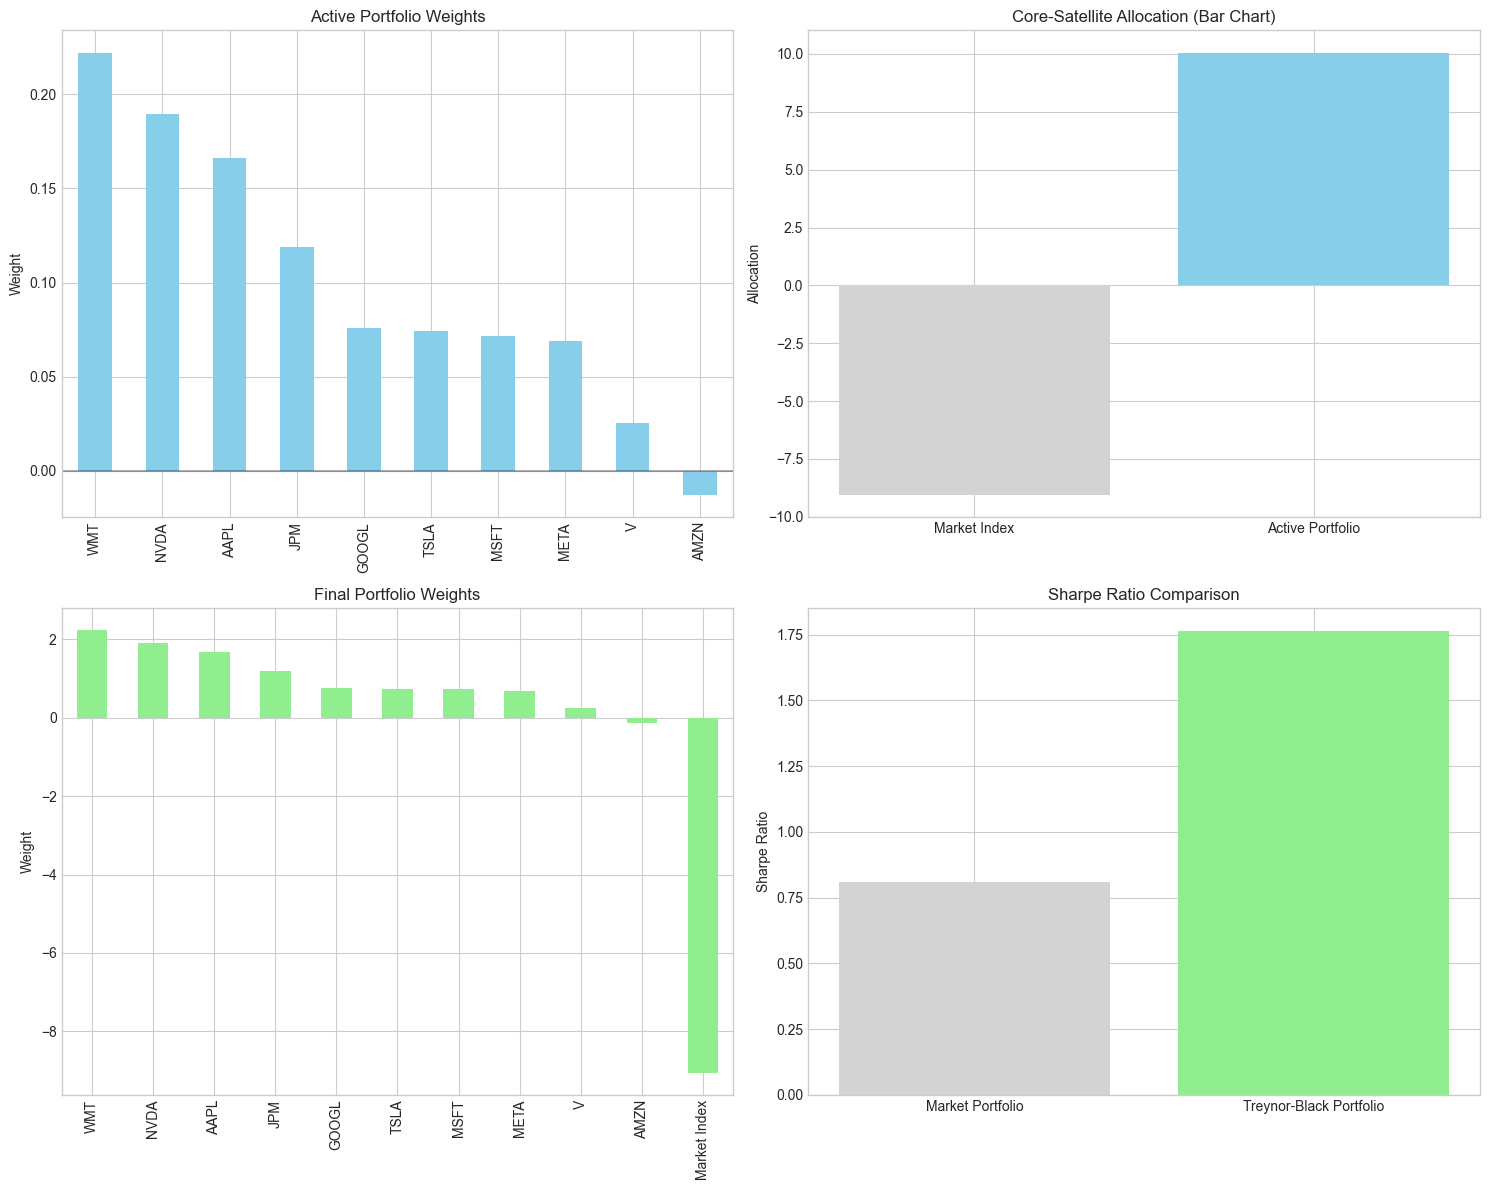

In [114]:
# Plot the results
fig = plot_treynor_black_results(tb_results, market_ticker, stock_tickers)

## 6. Create a function to implement Treynor-Black with custom alpha views

Let's create a function that allows us to input our own alpha views for specific stocks

In [115]:
def treynor_black_with_custom_alphas(stock_tickers, market_ticker, start_date, end_date,
                                     custom_alphas=None, annual_rf=0.03):
    """
    Implement Treynor-Black model with custom alpha views
    
    Parameters:
    -----------
    stock_tickers : list
        List of stock ticker symbols
    market_ticker : str
        Market index ticker symbol
    start_date : datetime
        Start date for historical data
    end_date : datetime
        End date for historical data
    custom_alphas : dict, optional
        Dictionary of custom alpha values for specific stocks
    annual_rf : float, optional
        Annual risk-free rate
        
    Returns:
    --------
    dict
        Dictionary containing all Treynor-Black model results
    """
    # 1. Download data
    tickers = [market_ticker] + stock_tickers
    returns = get_stock_data(tickers, start_date, end_date)

    # Calculate excess returns
    daily_rf = annual_rf / 252
    excess_returns = returns.subtract(daily_rf, axis=0)

    # 2. Run Single Index Model estimation
    sim_results = estimate_single_index_model(excess_returns, len(tickers)-1)

    # 3. Apply custom alpha views if provided
    if custom_alphas:
        for ticker in sim_results['alpha']:
            if ticker in custom_alphas:
                sim_results['alpha'][ticker] = custom_alphas[ticker]
            else:
                sim_results['alpha'][ticker] = 0

    # 4. Calculate market variance
    market_variance = np.var(excess_returns.iloc[:, -1].values, ddof=1) * 252
    market_excess_return = np.mean(excess_returns.iloc[:,-1].values) * 252  # Annualized


    print(market_excess_return)
    print(np.sqrt(market_variance))
    print(market_excess_return/np.sqrt(market_variance))

    # 5. Run Treynor-Black model
    tb_results = treynor_black_model(
        sim_results['alpha'],
        sim_results['beta'],
        sim_results['residual_var'],
        market_variance,
        annual_rf,
        market_excess_return
    )

    # 6. Add SIM results for reference
    tb_results['sim_results'] = sim_results

    return tb_results


## 7. Example with Custom Alpha Views
Let's apply the model with some custom alpha views



[*********************100%***********************]  11 of 11 completed

0.14354527651251064
0.1771672251453429
0.8102247827991336
{'alpha': {'AAPL': 0.01, 'AMZN': -0.02, 'GOOGL': 0, 'JPM': 0, 'META': 0, 'MSFT': 0.02, 'NVDA': 0, 'TSLA': 0, 'V': 0, 'WMT': 0}, 'beta': {'AAPL': np.float64(1.1974005058883508), 'AMZN': np.float64(1.3330340494487207), 'GOOGL': np.float64(1.2575102746554983), 'JPM': np.float64(0.9664202432663018), 'META': np.float64(1.4967192323487868), 'MSFT': np.float64(1.1875264256257951), 'NVDA': np.float64(2.009763821592032), 'TSLA': np.float64(1.8605346294990353), 'V': np.float64(0.9634813722789778), 'WMT': np.float64(0.4156839098953667)}, 'residual_var': {'AAPL': np.float64(0.0384581604195322), 'AMZN': np.float64(0.06766529806617275), 'GOOGL': np.float64(0.04684539004380919), 'JPM': np.float64(0.049789204987854524), 'META': np.float64(0.1198430785908924), 'MSFT': np.float64(0.029710193178499787), 'NVDA': np.float64(0.1495678560039265), 'TSLA': np.float64(0.2994962243158228), 'V': np.float64(0.029564570364059475), 'WMT': np.float64(0.0378778

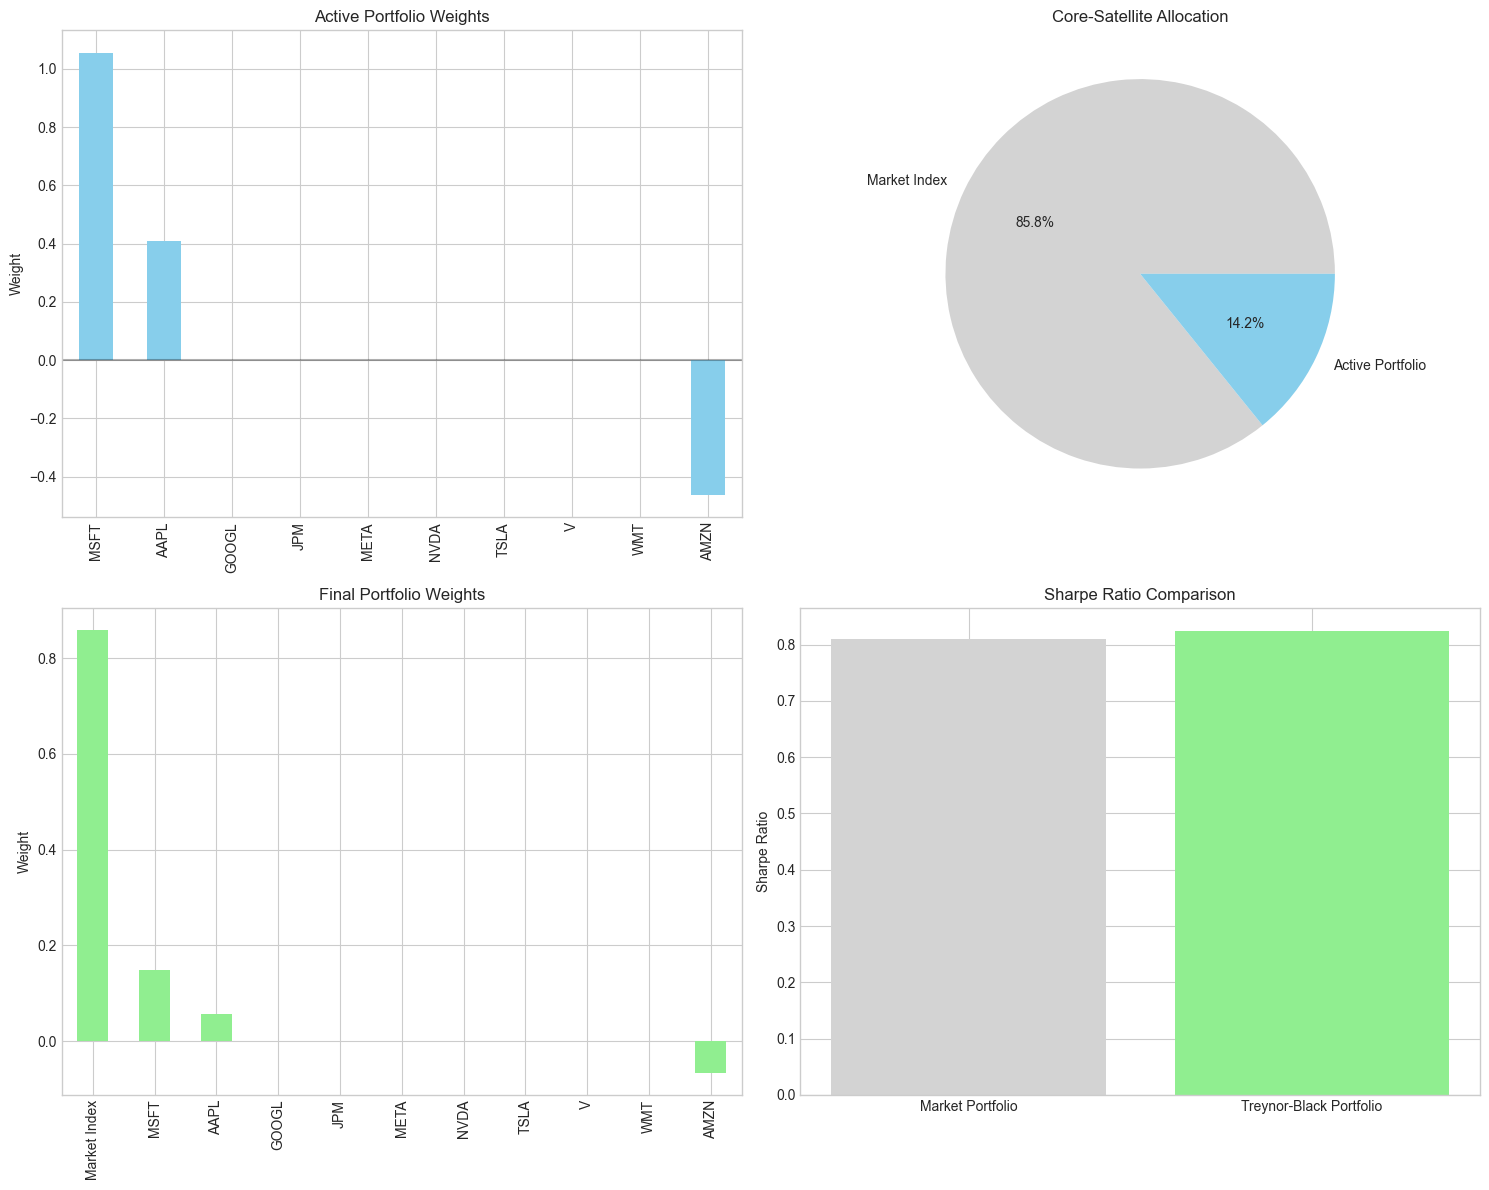

In [116]:

# Custom alpha views (annualized)
# Implicatino is others are 0
custom_alphas = {
    'AAPL': 0.01,  # 1% alpha
    'MSFT': 0.02,  # 2% alpha
    'AMZN': -0.02  # -2% alpha
}

# Run Treynor-Black with custom alphas
custom_tb_results = treynor_black_with_custom_alphas(
    stock_tickers,
    market_ticker,
    start_date,
    end_date,
    custom_alphas=custom_alphas
)

print(custom_tb_results['sim_results'])
# Plot results with custom alphas
custom_fig = plot_treynor_black_results(
    custom_tb_results, market_ticker, stock_tickers)

## 8. Performance Evaluation: Backtest

Let's implement a basic backtest to compare the Treynor-Black portfolio with a market index portfolio


In [117]:
def backtest_treynor_black(returns, tb_results, window=252, rebalance_freq=63):
    """
    Backtest the Treynor-Black model against a market index
    
    Parameters:
    -----------
    returns : DataFrame
        DataFrame containing returns for market and individual stocks
    tb_results : dict
        Dictionary of Treynor-Black model results
    window : int
        Lookback window for parameter estimation
    rebalance_freq : int
        Frequency of rebalancing in days
        
    Returns:
    --------
    DataFrame
        DataFrame containing portfolio values over time
    """
    # Create a copy of returns to avoid modifying the original
    returns_copy = returns.copy()

    # Initialize portfolio values
    portfolio_values = pd.DataFrame(index=returns_copy.index)
    portfolio_values['Market'] = 100
    portfolio_values['Treynor-Black'] = 100

    # Get initial weights
    market_weight = tb_results['market_portfolio_allocation']
    stock_weights = tb_results['final_weights']

    # Combine weights into a single Series
    all_weights = stock_weights.copy()
    all_weights.fillna(0, inplace=True)

    # Start from window size to have enough data for initial estimation
    current_value_tb = 100
    current_value_market = 100

    for i in range(window, len(returns_copy), rebalance_freq):
        # Get data for this period
        period_returns = returns_copy.iloc[i:min(
            i+rebalance_freq, len(returns_copy))]

        # Calculate period returns for the portfolios
        market_returns = period_returns.iloc[:, 0]  # Market returns

        # Treynor-Black portfolio returns
        tb_portfolio_returns = pd.Series(0, index=period_returns.index)
        for ticker in all_weights.index:
            if ticker in period_returns.columns:
                weight = all_weights[ticker]
                tb_portfolio_returns += weight * period_returns[ticker]

        # Add market component to TB portfolio
        tb_portfolio_returns += market_weight * market_returns

        # Update portfolio values
        for j, date in enumerate(period_returns.index):
            # Market portfolio
            current_value_market *= (1 + market_returns.iloc[j])

            # Treynor-Black portfolio
            current_value_tb *= (1 + tb_portfolio_returns.iloc[j])

            # Store values
            portfolio_values.loc[date, 'Market'] = current_value_market
            portfolio_values.loc[date, 'Treynor-Black'] = current_value_tb

    return portfolio_values



<Figure size 1200x600 with 0 Axes>

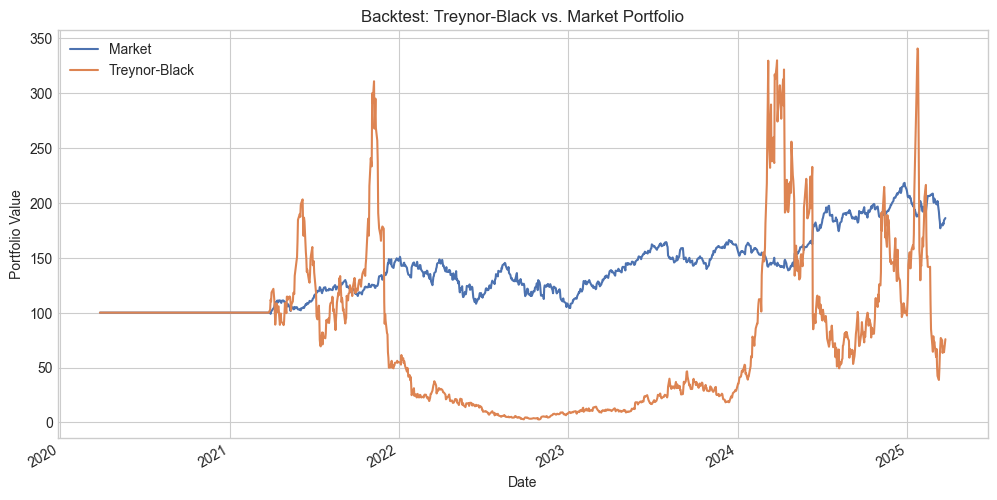

In [ ]:

# Run backtest (this uses a simplified approach without re-estimation)
backtest_results = backtest_treynor_black(returns, tb_results)

# Plot backtest results
plt.figure(figsize=(12, 6))
backtest_results.plot()
plt.title('Backtest: Treynor-Black vs. Market Portfolio')
plt.ylabel('Portfolio Value')
plt.xlabel('Date')
plt.grid(True)
plt.legend()


## 9. Create a simulated example like the one in the lecture slides

Let's recreate the Facebook and Twitter example from the slides

In [125]:
def simple_tb_example():
    """
    Recreate the simplified Treynor-Black example from the lecture slides
    with Facebook and Twitter
    """
    # Parameters from the slides
    market_returns = 0.09
    market_variance = 0.04
    risk_free_rate = 0.03

    # Stock parameters
    stocks = ['FB', 'TWTR']
    alphas = {'FB': 0.005, 'TWTR': 0.002}  # 0.5% and 0.2%
    betas = {'FB': 2.0, 'TWTR': 1.75}
    resid_vars = {'FB': 0.07, 'TWTR': 0.12}  # idiosyncratic variances

    # Calculate active portfolio weights
    alpha_div_resid = {stock: alphas[stock] /
                       resid_vars[stock] for stock in stocks}
    sum_alpha_div_resid = sum(alpha_div_resid.values())
    active_weights = {
        stock: alpha_div_resid[stock]/sum_alpha_div_resid for stock in stocks}

    # Calculate active portfolio characteristics
    active_alpha = sum(active_weights[stock]
                       * alphas[stock] for stock in stocks)
    active_beta = sum(active_weights[stock] * betas[stock] for stock in stocks)
    active_resid_var = sum(
        active_weights[stock]**2 * resid_vars[stock] for stock in stocks)

    # Calculate optimal allocation to active portfolio
    numerator = active_alpha / active_resid_var
    denominator = (market_returns - risk_free_rate) / market_variance + \
        (1 - active_beta) * (active_alpha / active_resid_var)
    weight_active = numerator / denominator
    weight_market = 1 - weight_active

    # Final weights
    final_weights = {
        stock: active_weights[stock] * weight_active for stock in stocks}

    # Print results
    print("Simplified Treynor-Black Example:")
    print(
        f"Active Portfolio Weights: FB = {active_weights['FB']:.2f}, TWTR = {active_weights['TWTR']:.2f}")
    print(
        f"Active Portfolio Characteristics: alpha = {active_alpha:.4f}, beta = {active_beta:.2f}, resid_var = {active_resid_var:.4f}")
    print(
        f"Allocation: Active = {weight_active:.2%}, Market = {weight_market:.2%}")
    print(
        f"Final Portfolio Weights: Market = {weight_market:.2%}, FB = {final_weights['FB']:.2%}, TWTR = {final_weights['TWTR']:.2%}")

    return {
        'active_weights': active_weights,
        'active_alpha': active_alpha,
        'active_beta': active_beta,
        'active_resid_var': active_resid_var,
        'weight_active': weight_active,
        'weight_market': weight_market,
        'final_weights': final_weights
    }



Simplified Treynor-Black Example:
Active Portfolio Weights: FB = 0.81, TWTR = 0.19
Active Portfolio Characteristics: alpha = 0.0044, beta = 1.95, resid_var = 0.0503
Allocation: Active = 6.22%, Market = 93.78%
Final Portfolio Weights: Market = 93.78%, FB = 5.04%, TWTR = 1.18%


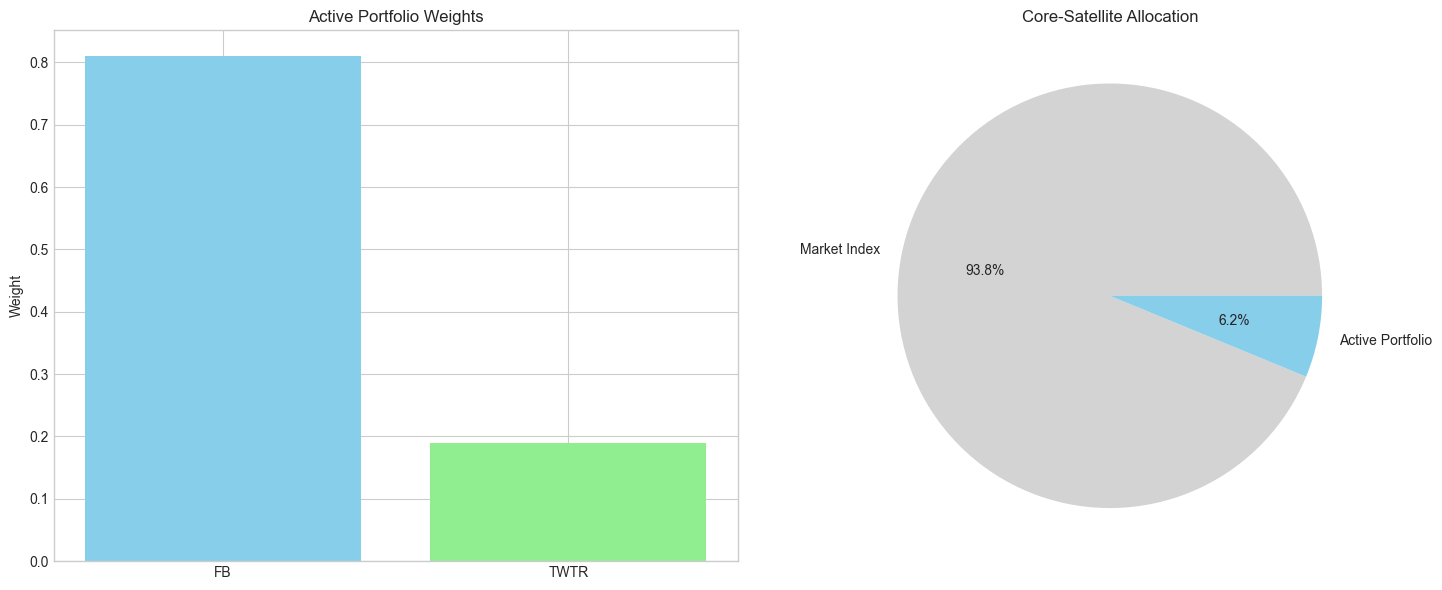

In [126]:

# Run the simple example
simple_example = simple_tb_example()

# Plot simple example results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Active portfolio weights
ax1.bar(['FB', 'TWTR'],
        [simple_example['active_weights']['FB'],
            simple_example['active_weights']['TWTR']],
        color=['skyblue', 'lightgreen'])
ax1.set_title('Active Portfolio Weights')
ax1.set_ylabel('Weight')

# Core-Satellite allocation
ax2.pie(
    [simple_example['weight_market'], simple_example['weight_active']],
    labels=['Market Index', 'Active Portfolio'],
    autopct='%1.1f%%',
    colors=['lightgray', 'skyblue']
)
ax2.set_title('Core-Satellite Allocation')

plt.tight_layout()



## 11. Summary and Conclusions

The Treynor-Black model provides a structured approach to combine active and passive investment strategies:

1. It starts with a single-factor model (CAPM) to estimate alpha, beta, and idiosyncratic risk
2. It constructs an active portfolio based on alpha/idiosyncratic risk ratio
3. It determines the optimal allocation between the active portfolio and the market index
4. It maximizes the Sharpe ratio of the overall portfolio

Key insights:
 - Higher alpha and lower idiosyncratic risk lead to larger weights in the active portfolio
 - The active weight increases with the active portfolio's alpha and decreases with its residual risk
 - The model balances the benefits of active management (alpha) with the benefits of diversification
 - It provides a disciplined approach to portfolio construction that can incorporate investor views